In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os
import chainer
from chainer.dataset import convert
import cv2
import net_conv
import hickle as hkl

In [ ]:
with open('../data/lifegame_data.pickle', 'rb') as f:
    d = pickle.load(f)
d[0] = np.array(list(map(lambda x: x.astype('float32'), d[0])))
with open('../data/lifegame_data_test.pickle', 'rb') as f:
    d_test = pickle.load(f)
d_test[0] = np.array(list(map(lambda x: x.astype('float32'), d_test[0])))
with open('../data/lifegame_data_glider.pickle', 'rb') as f:
    d_glider = pickle.load(f)
d_glider[0] = np.array(list(map(lambda x: x.astype('float32'), d_glider[0])))

In [ ]:
print(d[0].shape)
print(d_test[0].shape)
print(d_glider[0].shape)

In [ ]:
d[0][0].shape

In [2]:
X = hkl.load('D:/ShareData/kitti_data/X_train.hkl')
X = X / 255.
X = X.astype('float32')
sources = hkl.load('D:/ShareData/kitti_data/sources_train.hkl')

In [3]:
X2 = hkl.load('D:/ShareData/kitti_data/X_val.hkl')
X2 = X2 / 255.
X2 = X2.astype('float32')
sources2 = hkl.load('D:/ShareData/kitti_data/sources_val.hkl')

In [4]:
X3 = hkl.load('D:/ShareData/kitti_data/X_test.hkl')
X3 = X3 / 255.
X3 = X3.astype('float32')
sources3 = hkl.load('D:/ShareData/kitti_data/sources_test.hkl')

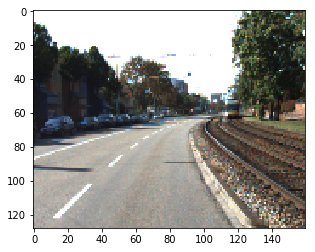

In [5]:
# plt.gray()

plt.imshow(X[0])

In [6]:
N = X[0].shape[1]
N2 = X[0].shape[2]
gpu = -1
dimz = 2
batchsize = 16
epoch = 10
initmodel = ''
resume = ''
out = 'result/KITTI'
is_test = False #'store_true'

In [7]:
print('GPU: {}'.format(gpu))
print('# dim z: {}'.format(dimz))
print('# Minibatch-size: {}'.format(batchsize))
print('# epoch: {}'.format(epoch))
print('')

GPU: -1
# dim z: 2
# Minibatch-size: 16
# epoch: 10



In [8]:
# Initialize / Resume
if initmodel:
    chainer.serializers.load_npz(initmodel, model)
if resume:
    chainer.serializers.load_npz(resume, optimizer)

In [9]:
test_for_plot = list()
for idx in range(len(X3)-1):
    test_for_plot.append(np.transpose(X3[idx], (2,0,1)))

In [10]:
train = list()
for idx in range(len(X)-1):
    if sources[idx] == sources[idx+1]:
        train.append((np.transpose(X[idx], (2,0,1)), np.transpose(X[idx+1], (2,0,1))))

In [11]:
len(train)

41339

In [12]:
test = list()
for idx in range(len(X2)-1):
    if sources2[idx] == sources2[idx+1]:
        test.append((np.transpose(X2[idx], (2,0,1)), np.transpose(X2[idx+1], (2,0,1))))

In [13]:
len(test)

153

In [62]:
# n = 38000
# test = train[n:]
# train = train[:n]

In [14]:
random.shuffle(train)
random.shuffle(test)

In [15]:
if is_test:
    train, _ = chainer.datasets.split_dataset(train, 100)
    test, _ = chainer.datasets.split_dataset(test, 100)
train_count = len(train)
test_count = len(test)

train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

In [16]:
model = net_conv.ConvAE_mini_RGB(input_size=N, input_size2=N2, n_filters=10, n_latent=dimz, filter_size=3, activation='relu')

from chainer import cuda
if gpu >= 0:
    cuda.get_device_from_id(gpu).use()
    model.to_gpu()

# Setup an optimizer
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [17]:
c = 1
while train_iter.epoch < epoch:
    sum_loss = 0
    batch = train_iter.next()
    x_array1 = convert.concat_examples(list(map(lambda x: x[0], batch)), gpu)
    x_array2 = convert.concat_examples(list(map(lambda x: x[1], batch)), gpu)
    x = chainer.Variable(x_array1)
    # Update model based on the loss function
    # defined by model.get_loss_func()
    optimizer.update(model.get_loss_func(), x, x_array2)
    sum_loss += float(model.loss.data) * len(x.data)
    if train_iter.is_new_epoch:
        print(c)
        c += 1
        print('train mean loss={}'.format(sum_loss / train_count))
        # evaluation
        sum_loss = 0
        for batch in test_iter:
            x_array1 = convert.concat_examples(list(map(lambda x: x[0], batch)), gpu)
            x_array2 = convert.concat_examples(list(map(lambda x: x[1], batch)), gpu)
            x = chainer.Variable(x_array1)
            loss_func = model.get_loss_func(k=10)
            loss_func(x, x_array2)
            sum_loss += float(model.loss.data) * len(x.data)
        test_iter.reset()
        print('test mean loss={}'.format(sum_loss / test_count))

1
train mean loss=11.78711537531145
test mean loss=31410.121642667484
2
train mean loss=11.65313097196352
test mean loss=31384.677351409315
3
train mean loss=11.848602409347105
test mean loss=31300.161203022875
4
train mean loss=11.483340489610296
test mean loss=31263.99578737745
5
train mean loss=11.463972429183096
test mean loss=31252.382621017157
6
train mean loss=12.21158817944314
test mean loss=31243.1544628268
7
train mean loss=11.920476880185781
test mean loss=31238.753357332516
8
train mean loss=11.819515167275455
test mean loss=31241.959456699347
9
train mean loss=11.530574941338687
test mean loss=31295.259829452614
10
train mean loss=11.111992458695179
test mean loss=31258.156224468956


In [18]:
# Note that os.makedirs(path, exist_ok=True) can be used
# if this script only supports python3
# if not os.path.exists(out):
#     os.mkdir(out)

# Save the model and the optimizer
print('save the model')
chainer.serializers.save_npz(os.path.join(out, 'model.model'), model)
print('save the optimizer')
chainer.serializers.save_npz(os.path.join(out, 'state.state'), optimizer)

save the model
save the optimizer


In [19]:
# Visualize the results
def save_images(x, filename):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(3, 3, figsize=(9, 9), dpi=100)
    for ai, xi in zip(ax.flatten(), x):
        ai.imshow(np.transpose(xi, (1,2,0)))
    fig.savefig(filename)

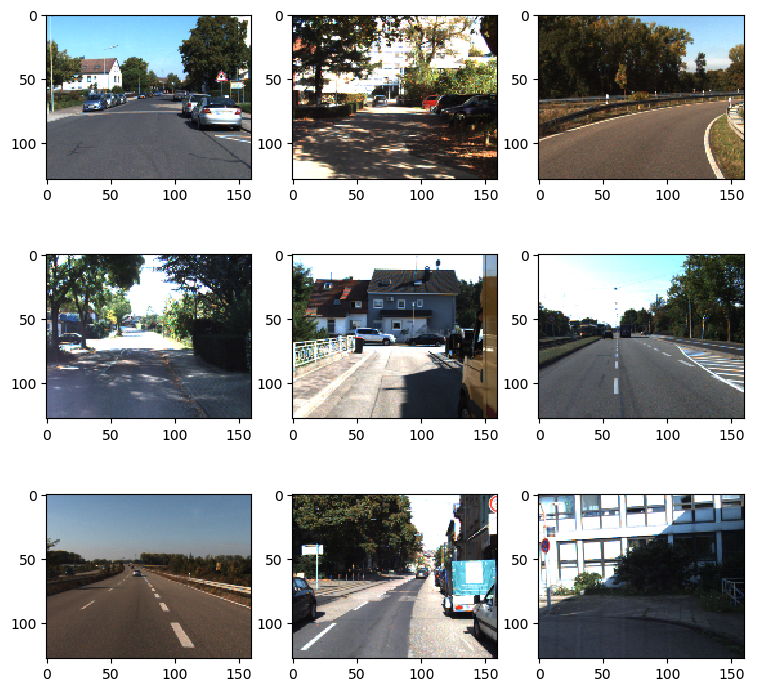

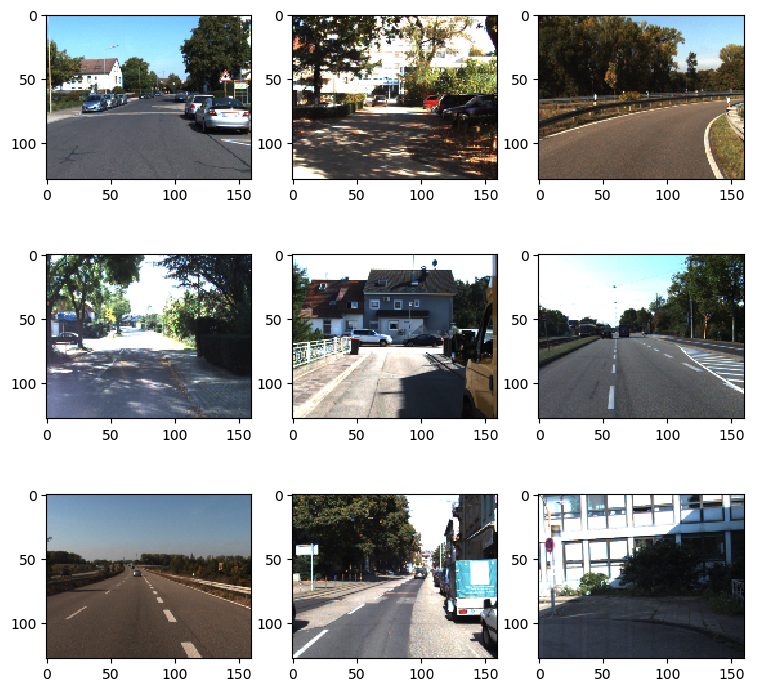

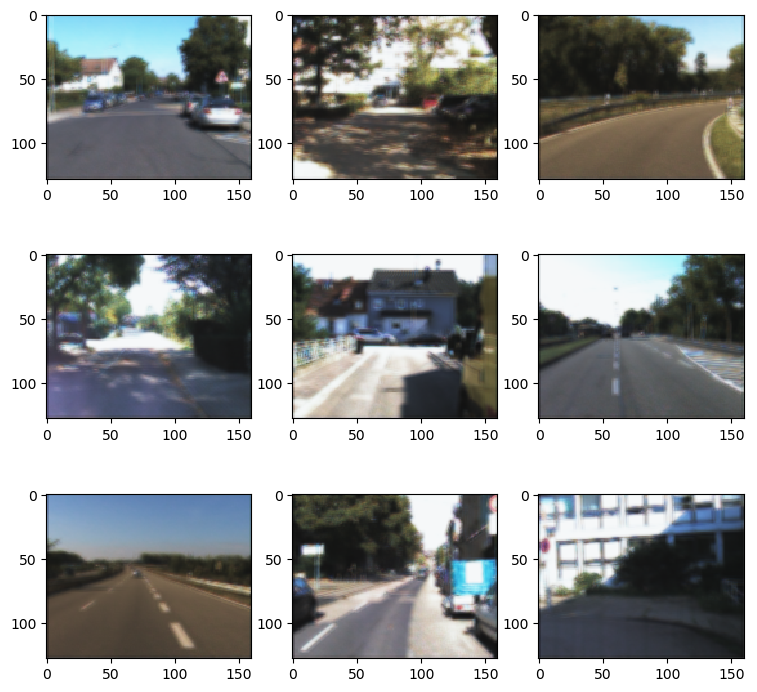

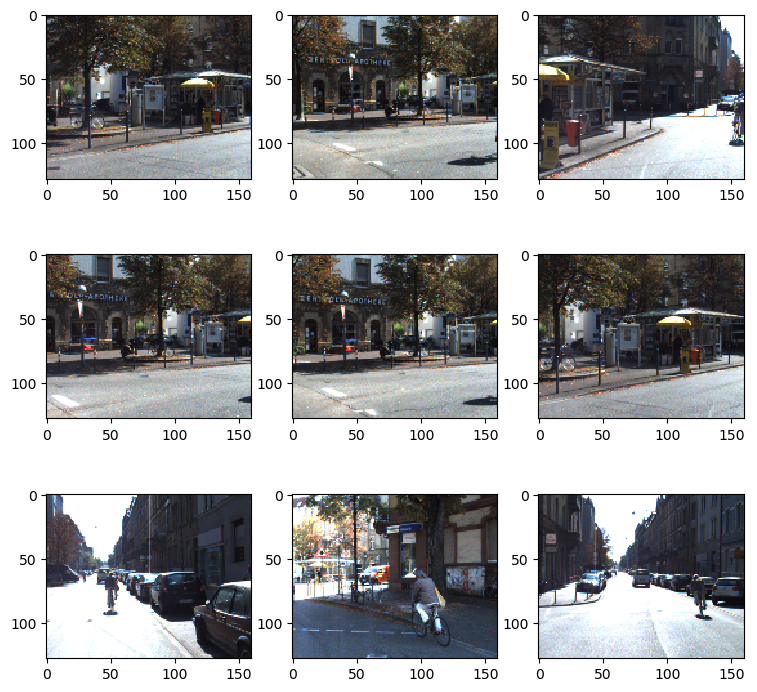

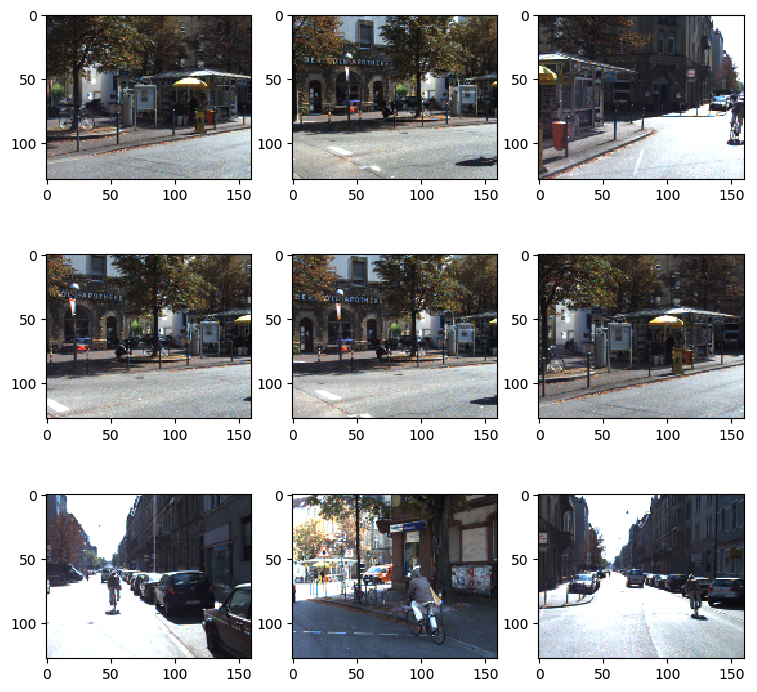

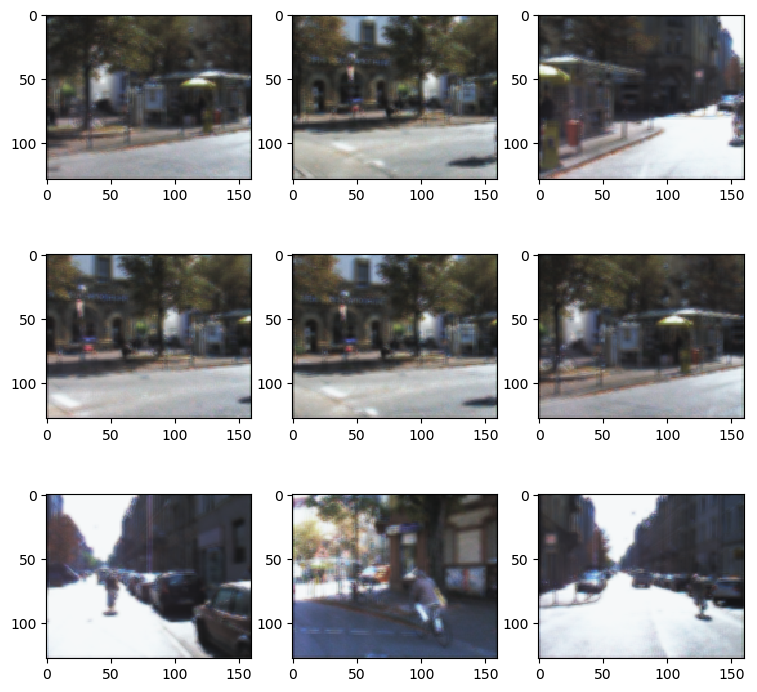

In [20]:
model.to_cpu()
train_ind = np.random.randint(0,len(train),9)
# train_ind = [0,1,2,3,4,5,6,7,8]
batch = np.asarray(train)[train_ind]
x_array1 = convert.concat_examples(list(map(lambda x: x[0], batch)), gpu)
x_array2 = convert.concat_examples(list(map(lambda x: x[1], batch)), gpu)
x = chainer.Variable(x_array1)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x1 = model(x)
save_images(x_array1, os.path.join(out, 'train_x'))
save_images(x_array2, os.path.join(out, 'train_xnext'))
save_images(x1.data, os.path.join(out, 'train_xnextreconstructed'))

# test_ind = np.random.randint(0,len(test),9)
test_ind = [0,1,2,3,4,5,6,7,8]
batch = np.asarray(test)[test_ind]
x_array1 = convert.concat_examples(list(map(lambda x: x[0], batch)), gpu)
x_array2 = convert.concat_examples(list(map(lambda x: x[1], batch)), gpu)
x = chainer.Variable(x_array1)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x1 = model(x)
save_images(x_array1, os.path.join(out, 'test_x'))
save_images(x_array2, os.path.join(out, 'test_xnext'))
save_images(x1.data, os.path.join(out, 'test_xnextreconstructed'))


plot for paper (same format with Prednet)

In [21]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import matplotlib.gridspec as gridspec

In [30]:
with open('X_test.pickle', 'rb') as f:
    X_test2 = pickle.load(f)
with open('X_hat.pickle', 'rb') as f:
    X_hat2 = pickle.load(f)    

In [36]:
len(test_for_plot)

831

In [40]:
# test_ind = [0,1,2,3,4,5,6,7,8,9]
test_ind = list(np.linspace(0, len(test_for_plot)-2, len(test_for_plot)-1, dtype='int32'))
batch = np.asarray(test_for_plot)[test_ind]
# test_ind = list(np.linspace(0, 9, 10, dtype='int32'))
# batch = np.asarray(test_for_plot_glider)[test_ind]
x_array1 = convert.concat_examples(list(map(lambda x: x, batch)), gpu)
x = chainer.Variable(x_array1)
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x1 = model(x)

In [41]:
x_array1.transpose(0,2,3,1).shape

(830, 128, 160, 3)

In [42]:
X_test = x_array1.transpose(0,2,3,1).reshape(int(x_array1.data.shape[0]/10), 10, 128, 160, 3)
X_hat = x1.data.transpose(0,2,3,1).reshape(int(x_array1.data.shape[0]/10), 10, 128, 160, 3)
# X_test = x_array1.transpose(0,2,3,1).reshape(int(x_array1.data.shape[0]/10), 10, 16, 20)
# X_hat = x1.data.transpose(0,2,3,1).reshape(int(x_array1.data.shape[0]/10), 10, 16, 20)
# X_test = np.array(list(map(lambda x: x.repeat(8, axis=1).repeat(8, axis=2), X_test)))
# X_hat = np.array(list(map(lambda x: x.repeat(8, axis=1).repeat(8, axis=2), X_hat)))

In [43]:
X_test.shape

(83, 10, 128, 160, 3)

In [31]:
# plt.gray()
nt = 10
aspect_ratio = 0.8
# plt.figure(figsize = (nt, 2*aspect_ratio))
plt.figure(figsize = (100/7.2, 16/7.2))
gs = gridspec.GridSpec(2, nt)
gs.update(wspace=0., hspace=0.)
plot_save_dir = 'fig_for_paper/KITTI/'
if not os.path.exists(plot_save_dir): os.mkdir(plot_save_dir)
plot_idx = np.random.permutation(X_test.shape[0])

for i in plot_idx:
    for t in range(nt):     
        plt.subplot(gs[t])
        plt.imshow(X_test[i,t], interpolation='none')
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
        if t==0: plt.ylabel('Actual', fontsize=10)

        plt.subplot(gs[t + nt])
        if t % 10 == 0:
            plt.imshow(X_hat2[0,0], interpolation='none')
        else:
            plt.imshow(X_hat[i,t-1], interpolation='none')
        plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
        if t==0: plt.ylabel('Predicted', fontsize=10)
    
    plt.savefig(plot_save_dir +  'plot_' + str(i) + '.png')
    plt.clf()
plt.close()

C:\Users\noda\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


In [44]:
mse_model = 0
mse_prev = 0
c = 0
for i in range(len(X_test)):
    for j in range(len(X_test[0])-1):
        mse_model += np.mean((X_test[i,j+1,:,:] - X_hat[i,j,:,:])**2)
        mse_prev += np.mean((X_test[i,j+1,:,:] - X_test[i,j,:,:])**2)        
        c += 1


In [45]:
mse_model/c

0.01645299174711906

In [46]:
mse_prev/c

0.021823189848399045